importing the required packages and libraries.

In [1]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.models import Sequential, model_from_json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from keras.callbacks import EarlyStopping


Using TensorFlow backend


Globale Variable

In [2]:
WORKSPACE_PATH = 'workspace'
LARGE_DATASET_ANNOTAIONS = '../data_zettel/Annotations'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
ORIGINAL_ANNOTATION_PATH = LARGE_DATASET_ANNOTAIONS #ANNOTATION_PATH+'/original'
IMAGE_PATH = WORKSPACE_PATH+'/images'
LARGE_DATASET_IMAGES = '../data_zettel/filled_resized'
ORIGINAL_IMAGE_PATH = LARGE_DATASET_IMAGES#IMAGE_PATH+'/original'
MODEL_PATH = WORKSPACE_PATH+'/models'
TEST_IMAGE_PATH = IMAGE_PATH +'/Bilder'

SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.0001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0
NEW_HEIGHT = 640
NEW_WIDTH = 640  

The Dataset Preparation

In [3]:
class_ids = [
"Ausbildung_Staette" ,
"Ausbildung_Klasse" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
"Person_Name",
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Geburtsort" ,
"Person_Geburtsdatum" ,
"Person_Familienstand" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
"Wohnsitz_Strasse",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz_Ort",
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_Ort",
"Ausbildung",
"Person" ,
"Wohnsitz",
"Wohnsitz_waehrend_Ausbildung" ,
]
sub_class_ids = [
#7
"Ausbildung_Staette" ,
"Ausbildung_Klasse" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
#10
"Person_Name",
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Geburtsort" ,
"Person_Geburtsdatum" ,
"Person_Familienstand" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
#6
"Wohnsitz_Strasse",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz_Ort",
#6
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_Ort",
]
main_class_ids=[
"Ausbildung",
"Person" ,
"Wohnsitz",
"Wohnsitz_waehrend_Ausbildung" ,
]
num_ausbildungs_ids = 7
num_personen_ids = 10
num_wohnsitz_ids = 6
num_wohnsitz_waehrend_ausbildung_ids = 6

class_mapping = dict(zip(range(len(class_ids)), class_ids))
main_class_mapping = dict(zip(range(len(main_class_ids)), main_class_ids))
sub_class_mapping = dict(zip(range(len(sub_class_ids)), sub_class_ids))

In [4]:
# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(ORIGINAL_ANNOTATION_PATH, file_name)
        for file_name in os.listdir(ORIGINAL_ANNOTATION_PATH)
        if file_name.endswith(".xml")
    ]
)
 
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(ORIGINAL_IMAGE_PATH, file_name)
        for file_name in os.listdir(ORIGINAL_IMAGE_PATH)
        if file_name.endswith(".jpg")
    ]
)

parsing the XML annotation files

In [5]:
def map_class_id(classes, cls):    
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return class_ids

def create_box(bbox):
    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)
    return [xmin, ymin, xmax, ymax]

In [6]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
 
    image_name = root.find("filename").text
    image_path = os.path.join(ORIGINAL_IMAGE_PATH, image_name)
    
    boxes = []
    classes = []
    main_classes = []
    sub_classes = []
    main_boxes = []
    sub_boxes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
 
        bbox = obj.find("bndbox")
        boxes.append( create_box(bbox))
        #main labels
        if (cls=='Wohnsitz_waehrend_Ausbildung')or(cls=='Ausbildung') or (cls =='Person') or (cls == 'Wohnsitz'):
            main_classes.append(cls)
            bbox = obj.find("bndbox")
            main_boxes.append( create_box(bbox))
        else:
            bbox = obj.find("bndbox")
            sub_boxes.append( create_box(bbox))
            sub_classes.append(cls)
    class_ids = map_class_id(classes, cls)
    main_class_ids = map_class_id(main_classes, cls)            
    sub_class_ids = map_class_id(sub_classes, cls)

    return image_path, boxes, class_ids, main_class_ids, sub_class_ids, main_boxes, sub_boxes, image_name
 

In [7]:
image_paths = []
image_names = []
bbox = []
classes = []
main_classes = []
sub_classes= []
main_bbox= []
sub_bbox= []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids, main_class_ids,sub_class_ids, main_boxes, sub_boxes, image_name = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)
    image_names.append(image_name)

    main_classes.append(main_class_ids)
    sub_classes.append(sub_class_ids)
    main_bbox.append(main_boxes)
    sub_bbox.append(sub_boxes)

subset_image_paths_all=image_paths
subset_boxes_all=sub_bbox

  0%|          | 0/81 [00:00<?, ?it/s]

In [8]:
#Sortieren der Klassen gemäß des Antrags von links nach rechts und von oben nach unten
#Gleichermaßen werden die boxen sortiert
def sort_rem_pos(sub_classes, sub_bbox):
    #Verketten von Pos und Wert
    enumerated_liste = list(enumerate(sub_classes))
    sorted_enumerated_liste = sorted(enumerated_liste, key=lambda x: x[1])

    sorted_classes = [item[1] for item in sorted_enumerated_liste]
    old_positions = [item[0] for item in sorted_enumerated_liste]

    sorted_sub_bbox = [sub_bbox[pos] for pos in old_positions]
    return sorted_classes, sorted_sub_bbox
        


In [9]:
sorted_classes = []
sorted_boxes = []

for i in range(len(sub_classes)):
    classes, boxes = sort_rem_pos(sub_classes[i], sub_bbox[i])
    sorted_classes.append(classes)
    sorted_boxes.append(boxes)

sub_classes = sorted_classes 
sub_bbox = sorted_boxes 
subset_class_ids_all=sub_classes

In [10]:
#Bilder richtig drehen, Boxen und Bilder an x Achse spiegeln
#Bilder die zu drehen sind: 36,37


def rotate(input_path):
    image = cv2.imread(input_path)
    rotated_image = cv2.rotate(image, cv2.ROTATE_180)
    cv2.imwrite(input_path, rotated_image)

def rotate_box(input_path, bounding_boxes):
    image = cv2.imread(input_path)
    rotated_boxes = []
    for bounding_box in bounding_boxes:
        rotated_box = (image.shape[1] - bounding_box[2],
                        image.shape[0] - bounding_box[3],
                        image.shape[1] - bounding_box[0],
                        image.shape[0] - bounding_box[1])
        rotated_boxes.append(rotated_box)
    return rotated_boxes

objects_to_rotate = [35,36]
for i in objects_to_rotate:
    main_bbox[i] = rotate_box('../data_zettel/filled_resized\image_00'+str(i)+'.jpg', main_bbox[i])

In [11]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (width, height))
    cv2.imwrite(output_path, resized_image)    
    
def scale_bounding_boxes(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)

    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    x_min = (bounding_boxes[0]*width_ratio)
    y_min = (bounding_boxes[1]*height_ratio)
    x_max = (bounding_boxes[2]*width_ratio)
    y_max = (bounding_boxes[3]*height_ratio)
    return [x_min,y_min,x_max,y_max]


In [12]:
#Create Images from main_classes
IMAGES_MAIN_CLASSES_PATH = IMAGE_PATH +'/640x640_main_classes'

def create_main_images(input_path, output_path, box):
    startY, endY, startX, endX = int(np.round(box[1])), int(np.round(box[3])), int(np.round(box[0])), int(np.round(box[2]))
    image =  cv2.imread(input_path)
    cropped_image = image[startY:endY, startX:endX]
    cv2.imwrite(output_path, cropped_image)  

box_ratio_factors = []
sub_box_calculated = []
main_images_paths = []
main_image_names = []

def calculate_box_ratio_factor(image_path,box):
    image = cv2.imread(image_path)
    box[2], box[2], box[2], box[2]
    relative_xbl = box[0] #/ width
    relative_ybl = box[1] #/ height
    relative_xtr = box[2] #/ width
    relative_ytr = box[3] #/ height
    return [relative_xbl,relative_ybl,relative_xtr,relative_ytr]

def array_calculation(sub_box, main_box):
    return [sub_box[0]-main_box[0],sub_box[1]-main_box[1],sub_box[2]-main_box[0],sub_box[3]-main_box[1]]

#Bilder ausschneiden und speichern
for i in range(len(main_class_ids)):
    for j in range(len(image_paths)):
        box_ratio_factors.append(calculate_box_ratio_factor(image_paths[j], main_bbox[j][i]))
        create_main_images(image_paths[j],IMAGES_MAIN_CLASSES_PATH+'/'+str(i)+'_'+str(j)+'.jpg', main_bbox[j][i])
        main_images_paths.append(IMAGES_MAIN_CLASSES_PATH+'/'+str(i)+'_'+str(j)+'.jpg')
        main_image_names.append(str(i)+'_'+str(j)+'.jpg')

#Resize Images auf 640x640
subsset_scaled_image_paths = []
for img in range(len(main_images_paths)):
    resize_imgaes(main_images_paths[img], IMAGE_PATH+ '/640x640_main_classes_scaled/' +main_image_names[img], 640, 640)
    subsset_scaled_image_paths.append(IMAGE_PATH+ '/640x640_main_classes_scaled/' +main_image_names[img])
#print(subsset_scaled_image_paths)

#Anpassen der Bounding Box Koordinaten zu dem jeweiligen Bildausschnitt
for i in range(len(main_class_ids)):
    for j in range(len(image_paths)):
        for k in range(len(sub_class_ids)):
            sub_box_calculated.append(array_calculation(sub_bbox[j][k], main_bbox[j][i]))



sub_boxes_main_class_1=[]  
sub_boxes_main_class_2=[] 
sub_boxes_main_class_3=[] 
sub_boxes_main_class_4=[] 
sub_boxes_all_main_classes=[]

scaled_sub_boxes_main_class_1=[]  
scaled_sub_boxes_main_class_2=[] 
scaled_sub_boxes_main_class_3=[] 
scaled_sub_boxes_main_class_4=[] 

#Boxen im Verhältnis der main_box zu 640x640 scalen
for i in range(len(image_names)): #81 Bilder
    for j in range(len(sub_class_ids)): #29 Klassen
        arr=[]
        if j < num_ausbildungs_ids: #Ausbildung
            sub_boxes_main_class_1.append(array_calculation(sub_bbox[i][j], main_bbox[i][0]))
            scaled_sub_boxes_main_class_1.append(scale_bounding_boxes(main_images_paths[i],sub_boxes_main_class_1[i],640,640))

        elif (j >= num_ausbildungs_ids) and (j < num_ausbildungs_ids + num_personen_ids) :#Person
            sub_boxes_main_class_2.append(array_calculation(sub_bbox[i][j], main_bbox[i][1]))
            scaled_sub_boxes_main_class_2.append(scale_bounding_boxes(main_images_paths[i+81],sub_boxes_main_class_2[i],640,640))
        elif (j >= num_ausbildungs_ids + num_personen_ids) and (j < num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids) :#Wohnsitz
            #sub_boxes_main_class_3.append(sub_bbox[i][j])
            sub_boxes_main_class_3.append(array_calculation(sub_bbox[i][j], main_bbox[i][2]))
            scaled_sub_boxes_main_class_3.append(scale_bounding_boxes(main_images_paths[i+162],sub_boxes_main_class_3[i],640,640))
        elif (j >=  num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids) and (j < num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids + num_wohnsitz_waehrend_ausbildung_ids) :#Wohnsitz_während_Ausildung
            sub_boxes_main_class_4.append(array_calculation(sub_bbox[i][j], main_bbox[i][3]))
            scaled_sub_boxes_main_class_4.append(scale_bounding_boxes(main_images_paths[i+243],sub_boxes_main_class_4[i],640,640))

In [13]:
def show_image(image, boxes):
    image = cv2.imread(image)

    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 

    # Bounding Boxes zeichnen
    for box in boxes:
        xmin, ymin, xmax, ymax = map(int, box)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

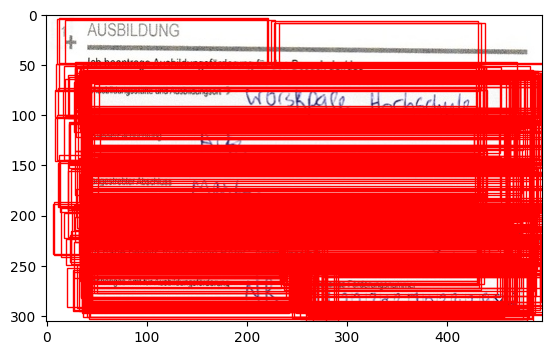

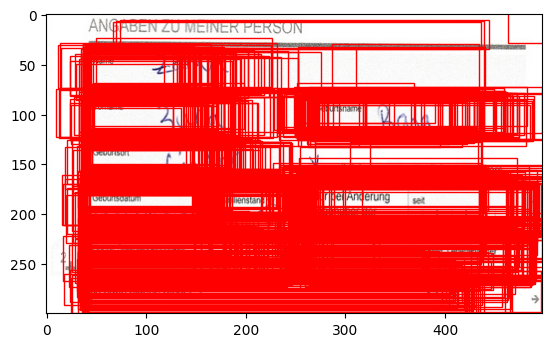

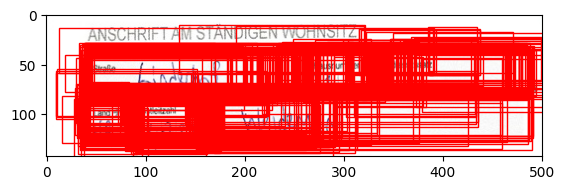

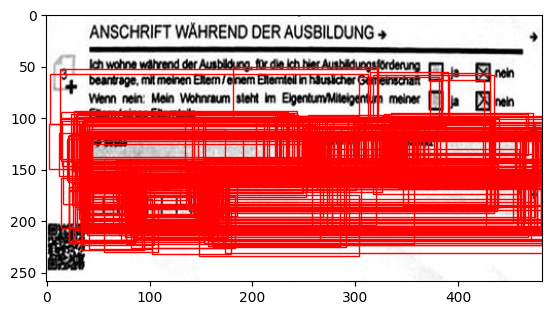

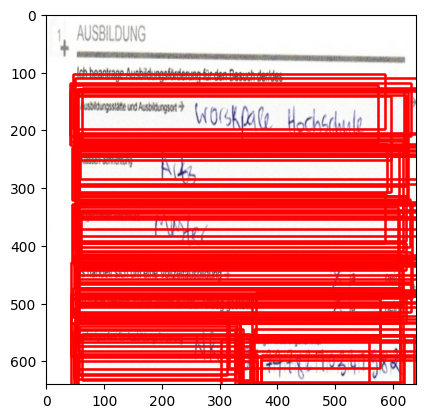

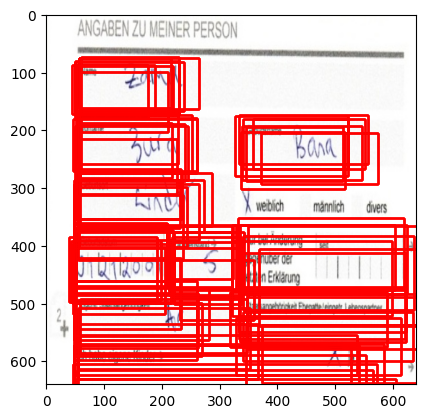

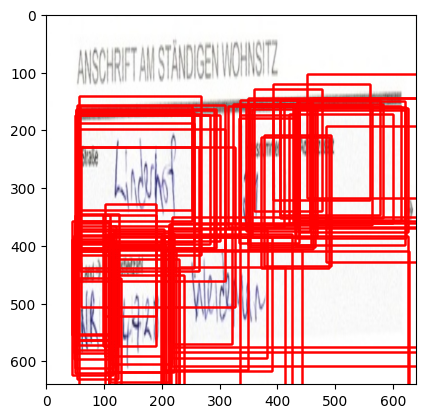

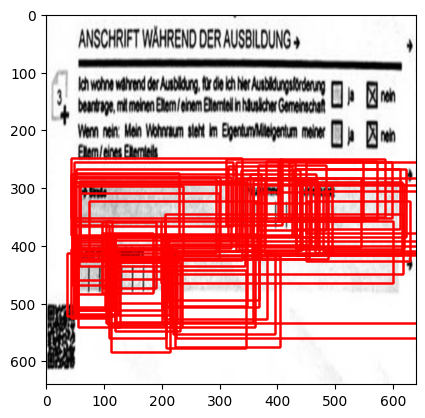

In [14]:
show_image(main_images_paths[0],sub_boxes_main_class_1)
show_image(main_images_paths[82],sub_boxes_main_class_2)
show_image(main_images_paths[170],sub_boxes_main_class_3)
show_image(main_images_paths[255],sub_boxes_main_class_4)

show_image(subsset_scaled_image_paths[0],scaled_sub_boxes_main_class_1)
show_image(subsset_scaled_image_paths[82],scaled_sub_boxes_main_class_2)
show_image(subsset_scaled_image_paths[170],scaled_sub_boxes_main_class_3)
show_image(subsset_scaled_image_paths[255],scaled_sub_boxes_main_class_4)

In [15]:
#create 4 datasets
#image_paths
#shape(81,x)
subset_images_paths_1 = []
subset_images_paths_2 = []
subset_images_paths_3 = []
subset_images_paths_4 = []
for i in range(len(subsset_scaled_image_paths)):
        if i < len(image_names): #Ausbildung
            subset_images_paths_1.append(subsset_scaled_image_paths[i])
        elif (i >= len(image_names)) and (i < (len(image_names)*2)) :#Person
            subset_images_paths_2.append(subsset_scaled_image_paths[i])
        elif (i >= (len(image_names)*2)) and (i < (len(image_names)*3)) :#Wohnsitz
            subset_images_paths_3.append(subsset_scaled_image_paths[i])
        elif (i >= (len(image_names)*3)) and (i < (len(image_names)*4)) :#Wohnsitz_während_Ausildung
            subset_images_paths_4.append(subsset_scaled_image_paths[i])
#classes
subset_class_ids_1_1 = []
subset_class_ids_2_2 = []
subset_class_ids_3_3 = []
subset_class_ids_4_4 = []
subset_class_ids_1 = []
subset_class_ids_2 = []
subset_class_ids_3 = []
subset_class_ids_4 = []
classes=[]
#shape(81,x)
for i in range(len(subset_class_ids_all[0])):
        if i < num_ausbildungs_ids: #Ausbildung
                subset_class_ids_1_1.append(subset_class_ids_all[0][i])
        elif (i >= num_ausbildungs_ids) and (i < num_ausbildungs_ids + num_personen_ids) :#Person
                subset_class_ids_2_2.append(subset_class_ids_all[0][i])
        elif (i >= num_ausbildungs_ids + num_personen_ids) and (i < num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids) :#Wohnsitz
                subset_class_ids_3_3.append(subset_class_ids_all[0][i])
        elif (i >= num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids) and (i < num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids + num_wohnsitz_waehrend_ausbildung_ids) :#Wohnsitz_während_Ausildung
                subset_class_ids_4_4.append(subset_class_ids_all[0][i])

for i in range (0,len(image_names)):
    subset_class_ids_1.append(subset_class_ids_1_1)
    subset_class_ids_2.append(subset_class_ids_2_2)
    subset_class_ids_3.append(subset_class_ids_3_3)
    subset_class_ids_4.append(subset_class_ids_4_4)

#boxen
subset_boxes_1 = []
subset_boxes_2 = []
subset_boxes_3 = []
subset_boxes_4 = []
#shape(18,x,4)
def shape_to_3_tupel(num_images, num_classes, scaled_boxes):
    subset_boxes = []
    arr= np.array(scaled_boxes)
    arr_1=arr.reshape(num_images,num_classes,4)
    for j in range(0,num_images):
        arr_1_1=[]
        for i in range(0,num_classes):
            arr_1_1.append(arr_1[i][0])
        subset_boxes.append(arr_1_1)
    return subset_boxes


subset_boxes_1 = shape_to_3_tupel(len(image_names), num_ausbildungs_ids, scaled_sub_boxes_main_class_1)
subset_boxes_2 = shape_to_3_tupel(len(image_names), num_personen_ids, scaled_sub_boxes_main_class_2)
subset_boxes_3 = shape_to_3_tupel(len(image_names), num_wohnsitz_ids, scaled_sub_boxes_main_class_3)
subset_boxes_4 = shape_to_3_tupel(len(image_names), num_wohnsitz_waehrend_ausbildung_ids, scaled_sub_boxes_main_class_4)

In [16]:
main_class_ids = []
for i in range(len(subset_image_paths_all)):
    main_class_ids.append([0,1,2,3])

In [17]:
#Entfernen fehlerhafter Annotationen aus Datensatz
#main
indexes_of_false_annotations_main = [31,31,31]
main_image_names = []


for img in subset_image_paths_all:
    main_image_names.append(img)

for index in indexes_of_false_annotations_main:
    main_bbox.pop(index)
    main_image_names.pop(index)
    main_class_ids.pop(index)

#sub 
indexes_of_false_annotations_sub = [31,31,31]


def pop_annotaions(classes, images, boxes, indexes):
    for index in indexes:
        boxes.pop(index)
        images.pop(index)
        classes.pop(index)

pop_annotaions(subset_class_ids_1, subset_images_paths_1, subset_boxes_1, indexes_of_false_annotations_sub)
pop_annotaions(subset_class_ids_2, subset_images_paths_2, subset_boxes_2, indexes_of_false_annotations_sub)
pop_annotaions(subset_class_ids_3, subset_images_paths_3, subset_boxes_3, indexes_of_false_annotations_sub)
pop_annotaions(subset_class_ids_4, subset_images_paths_4, subset_boxes_4, indexes_of_false_annotations_sub)

#pop_annotaions(subset_class_ids_4, subset_images_paths_4, subset_boxes_4, indexes_of_false_annotations_sub)

In [18]:
classes=[]
images=[]
box=[]
#shape (324,) subset aus 4 main_boxen
for i in range(len(subset_boxes_1)):
    box.append(subset_boxes_1[i])
    images.append(subset_images_paths_1[i])
    classes.append(subset_class_ids_1[i])
for i in range(len(subset_boxes_2)):
    box.append(subset_boxes_2[i])
    images.append(subset_images_paths_2[i])
    classes.append(subset_class_ids_2[i])
for i in range(len(subset_boxes_3)):
    box.append(subset_boxes_3[i])
    images.append(subset_images_paths_3[i])
    classes.append(subset_class_ids_3[i])
for i in range(len(subset_boxes_4)):
    box.append(subset_boxes_4[i])
    images.append(subset_images_paths_4[i])
    classes.append(subset_class_ids_4[i])

#hinzugügen des sets der ganzen Seite
"""for i in range(len(subset_boxes_all)):
    box.append(subset_boxes_all[i])
    images.append(subset_image_paths_all[i])
    classes.append(subset_class_ids_all[i])"""

'for i in range(len(subset_boxes_all)):\n    box.append(subset_boxes_all[i])\n    images.append(subset_image_paths_all[i])\n    classes.append(subset_class_ids_all[i])'

In [19]:
#überprüfen der Boxen
"""for i in range(len(main_image_names)):
    print(i)
    show_image(main_image_names[i], main_bbox[i])"""

"""for i in range(len(images)):
    print(i)
    show_image(images[i], box[i])"""

'for i in range(len(images)):\n    print(i)\n    show_image(images[i], box[i])'

In [20]:
def create_data_tensor(image_paths,classes,bbox):
    bbox = tf.ragged.constant(bbox, dtype=tf.float32)
    classes = tf.ragged.constant(classes, dtype=tf.int64)
    image_paths = tf.ragged.constant(image_paths, dtype=tf.string)
    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
    return data

In [21]:
new_sub_data_all = create_data_tensor(images,classes, box )
main_boxes_data = create_data_tensor(main_image_names, main_class_ids, main_bbox )

In [22]:
def create_train_test_data(split, data_tensor):
    num_val = int(split * SPLIT_RATIO)#int(len(image_path_list)
    val_data = data_tensor.take(num_val)
    train_data = data_tensor.skip(num_val)
    return val_data, train_data

In [23]:
#Bilder durchmischen
new_sub_data_all = new_sub_data_all.shuffle(len(images), reshuffle_each_iteration=True)
main_boxes_data = main_boxes_data.shuffle(len(main_image_names), reshuffle_each_iteration=True)

In [24]:
sub_val_data_all, sub_train_data_all  = create_train_test_data(len(images) , new_sub_data_all)
main_val_data_all, main_train_data_all  = create_train_test_data(len(main_image_names) , main_boxes_data)

In [25]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image
 

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [26]:
augmenter = keras.Sequential(
    layers=[
        #keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        #keras_cv.layers.RandomRotation(factor=0.2, bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            #target_size=(1344, 768),
            scale_factor=(1, 1),
            bounding_box_format="xyxy",
        )
        ,
    ]
)

In [27]:
def augment_brightness_and_contrast(data_dict):
    # Apply brightness and contrast augmentation
    data_dict["images"] = tf.image.random_brightness(data_dict["images"], max_delta=0.5)
    data_dict["images"] = tf.image.random_contrast(data_dict["images"], lower=0.7, upper=1)
    
    return data_dict

In [28]:
def create_train_ds(train_data):
    train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment_brightness_and_contrast, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(BATCH_SIZE * 8)
    train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
    return train_ds

In [29]:
sub_train_ds_all = create_train_ds(sub_train_data_all)
main_train_ds_all = create_train_ds(main_train_data_all)

In [30]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    #target_size=(1344, 768),
    scale_factor=(1, 1),
    bounding_box_format="xyxy",
)

def create_val_ds(val_data):
    val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.shuffle(BATCH_SIZE * 8)
    val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
    return val_ds

In [31]:
sub_val_ds_all= create_train_ds(sub_val_data_all)
main_val_ds_all= create_train_ds(main_val_data_all)

In [32]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.2,
        bounding_box_format=bounding_box_format,
        class_mapping=sub_class_mapping,
    )

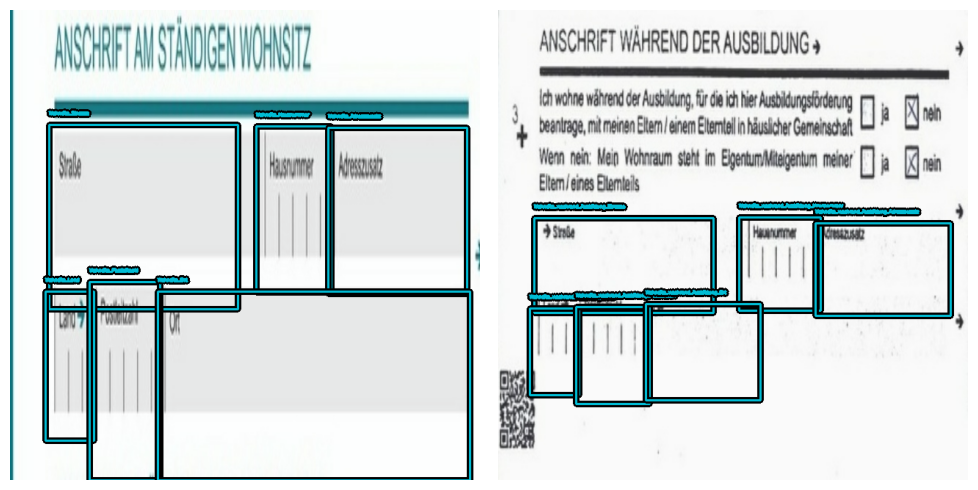

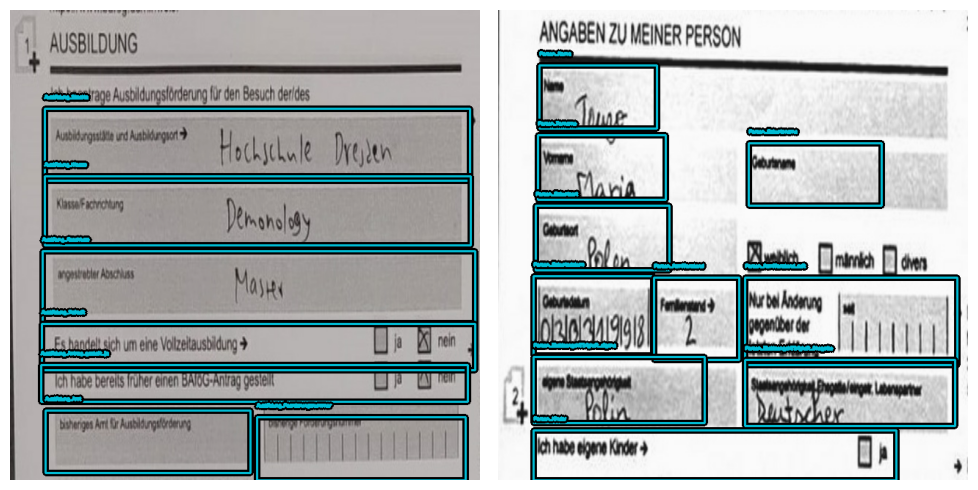

In [33]:
visualize_dataset(sub_train_ds_all, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=2)
visualize_dataset(sub_val_ds_all, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=2)

In [34]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

def create_train_val_tuple(train_ds,val_ds):
    train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds


In [35]:
sub_train_ds_all,sub_val_ds_all=create_train_val_tuple(sub_train_ds_all,sub_val_ds_all)
main_train_ds_all,main_val_ds_all=create_train_val_tuple(main_train_ds_all,main_val_ds_all)


define backbone

In [36]:
def define_backbone(backbone):
    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_xs_backbone_coco",
         load_weights=True 
    )
    return backbone

define optimizer

In [37]:
def define_optimizer():
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        global_clipnorm=GLOBAL_CLIPNORM, #This ensures that gradients, which influence the model’s parameter updates, 
                                        # don’t become exceedingly large and destabilize training.
    )
    return optimizer

define YOLO8Detector

In [38]:
def define_model(num_classes):
    model = keras_cv.models.YOLOV8Detector(
    num_classes=num_classes, #the number of object classes
    bounding_box_format="xyxy",
    backbone=define_backbone("yolo_v8_xs_backbone_coco"),
    fpn_depth=1,
)
    return model

compile model

In [39]:
def compile_model(model):
    model.compile(
    optimizer=define_optimizer(), 
    classification_loss="binary_crossentropy", 
    box_loss="ciou" 
)

fit model

In [40]:
early_stopping = EarlyStopping(monitor='loss',  
                               patience=3,          
                               restore_best_weights=True)  

callbacks = [early_stopping]

def fit_model(model, train_data, validation_data):
    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=EPOCH,
        callbacks=early_stopping,
        #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "workspace/models/yolo_coco_model.h5")],
    )
    return history

define NonMaxSuppression

In [41]:
def define_NonMaxSuppression(model):
    model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
        bounding_box_format="xyxy",
        from_logits=True,
        iou_threshold=0.9,
        confidence_threshold=0.5
    
    )

define a base model, compile the base model and then loads the weights from a path

In [42]:
def load_weight_model(model_path):
    base_model = define_model(len(class_mapping))
    compile_model(base_model)
    loaded_model = base_model.load_weights(model_path)
    return  loaded_model
    

save weights of a model

In [43]:
def save_weights(model, name):
    save_model_path = MODEL_PATH + name
    model.save_weights(save_model_path)

define visualization methode

In [44]:
def visualize_detections(model, dataset, bounding_box_format, class_mapping):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=5,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.4,
        class_mapping= class_mapping ,#class_mapping,
    )

define and compile model for sub_bbox

In [45]:
#MAIN_MODEL_PATH = MODEL_PATH+'/main_bbox_detector_model.h5'
SUB_BOX_MODEL = MODEL_PATH+'/large_ds_subbox_v2.h5'

yolo_coco_sub = define_model(len(sub_class_mapping))
yolo_coco_sub.load_weights(SUB_BOX_MODEL)
compile_model(yolo_coco_sub)

define and compile model for main_bbox

In [46]:
yolo_coco_main = define_model(len(main_class_mapping))
compile_model(yolo_coco_main)

fit main_bbox_model

In [47]:
#main_bbox_history_all= fit_model(yolo_coco_main, main_train_ds_all, main_val_ds_all)

fit sub_bbox_model

In [48]:
#sub_bbox_history_all= fit_model(yolo_coco_sub,sub_train_ds_all,sub_val_ds_all )

Plots

In [49]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))
    # Box Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['box_loss'], label='Training Box Loss')
    plt.plot(history.history['val_box_loss'], label='Validation Box Loss')
    plt.title('Training and Validation Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Loss')
    plt.legend()

    # Klassen Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_loss'], label='Training Class Loss')
    plt.plot(history.history['val_class_loss'], label='Validation Class Loss')
    plt.title('Training and Validation Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Class Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [50]:
#plot_metrics(sub_bbox_history_all)

In [51]:
#plot_metrics(sub_bbox_history_all)

visualization main bbox

visualization sub bbox

1/1 [==============================] - 4s 4s/step


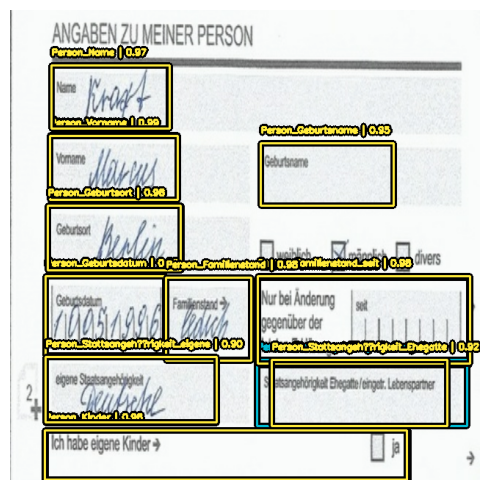

In [52]:
visualize_detections(yolo_coco_sub, dataset=sub_val_ds_all, bounding_box_format="xyxy", class_mapping= sub_class_mapping)

save weights

In [53]:
#MAIN_MODEL_PATH = MODEL_PATH+'/main_bbox_detector_model.h5'
#SUB_BOX_MODEL = MODEL_PATH+'/large_ds_subbox_v2.h5'

#yolo_coco_sub.save_weights(SUB_BOX_MODEL)

visualize a prediction with loaded_sub_model

In [54]:
def predict_on_main_image(image, model):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (1344, 768))
    resized_image = np.expand_dims(resized_image, axis=0)  

    # Predict
    predictions = model.predict(resized_image)
    boxes = predictions['boxes']
    confidence = predictions['confidence']
    classes = predictions['classes']

    sorted_indices = np.argsort(-confidence[0])  
    boxes = boxes[0][sorted_indices]
    confidence = confidence[0][sorted_indices]
    classes = classes[0][sorted_indices]

    unique_classes = np.unique(classes)
    selected_indices = []

    for cls in unique_classes:
        cls_indices = np.where(classes == cls)[0]
        if len(cls_indices) > 0:
            best_idx = cls_indices[0]  
            selected_indices.append(best_idx)

    selected_boxes = boxes[selected_indices]
    selected_confidence = confidence[selected_indices]
    selected_classes = classes[selected_indices]

    iou_threshold = 0.5

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for box, conf, cls in zip(selected_boxes, selected_confidence, selected_classes):
        if conf > 0.1:
            xmin, ymin, xmax, ymax = box
            label = f"Class {cls} ({conf:.2f})"
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none' ,label=label)
            ax.add_patch(rect)

    plt.legend()
    plt.show()
    return selected_boxes, selected_classes

In [55]:
def predict_on_image(image_path, model):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (640, 640))
    resized_image = np.expand_dims(resized_image, axis=0)  

    # Predict
    predictions = model.predict(resized_image)
    boxes = predictions['boxes']
    confidence = predictions['confidence']
    classes = predictions['classes']

    sorted_indices = np.argsort(-confidence[0])  
    boxes = boxes[0][sorted_indices]
    confidence = confidence[0][sorted_indices]
    classes = classes[0][sorted_indices]

    unique_classes = np.unique(classes)
    selected_indices = []

    for cls in unique_classes:
        cls_indices = np.where(classes == cls)[0]
        if len(cls_indices) > 0:
            best_idx = cls_indices[0]  
            selected_indices.append(best_idx)

    selected_boxes = boxes[selected_indices]
    selected_confidence = confidence[selected_indices]
    selected_classes = classes[selected_indices]

    iou_threshold = 0.5

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for box, conf, cls in zip(selected_boxes, selected_confidence, selected_classes):
        if conf > 0.1:
            xmin, ymin, xmax, ymax = box
            label = f"Class {cls} ({conf:.2f})"
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none' ,label=label)
            ax.add_patch(rect)

    plt.legend()
    plt.show()
    return selected_boxes, selected_classes

In [56]:
#load main model
MAIN_MODEL_PATH = MODEL_PATH+'/main_bbox_detector_model.h5'

yolo_coco_main.save_weights(MAIN_MODEL_PATH)
"""
yolo_coco_main = define_model(len(main_class_mapping))
yolo_coco_main.load_weights(MAIN_MODEL_PATH)
compile_model(yolo_coco_main)"""

'\nyolo_coco_main = define_model(len(main_class_mapping))\nyolo_coco_main.load_weights(MAIN_MODEL_PATH)\ncompile_model(yolo_coco_main)'

1/1 [==============================] - 3s 3s/step


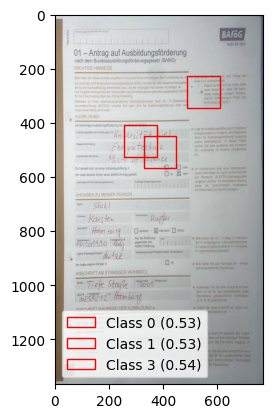

[[328.50906 448.52582 448.10516 567.7251 ]
 [488.04956 224.36671 608.08734 343.75443]
 [255.72891 408.70322 376.03098 527.29816]]


In [57]:
image_path2 = (LARGE_DATASET_IMAGES+'/image_0055.jpg') 
selected_main_boxes, selected_main_classes = predict_on_main_image(image_path2, yolo_coco_main)
print(selected_main_boxes)

In [58]:
def crop_main_images(input_path, box):
    startY, endY, startX, endX = int(np.round(box[1])), int(np.round(box[3])), int(np.round(box[0])), int(np.round(box[2]))
    image =  cv2.imread(input_path)
    cropped_image = image[startY:endY, startX:endX]
    return cropped_image

In [61]:
"""main_box_predictions = []
for i in range(len(selected_main_boxes)):
    main_box_predictions.append(crop_main_images(image_path2, selected_main_boxes))"""

'main_box_predictions = []\nfor i in range(len(selected_main_boxes)):\n    main_box_predictions.append(crop_main_images(image_path2, selected_main_boxes))'

1/1 [==============================] - 3s 3s/step


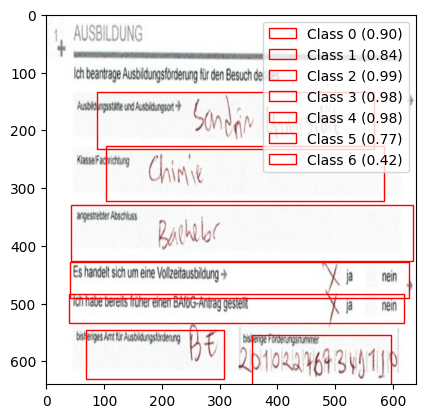

1/1 [==============================] - 0s 153ms/step


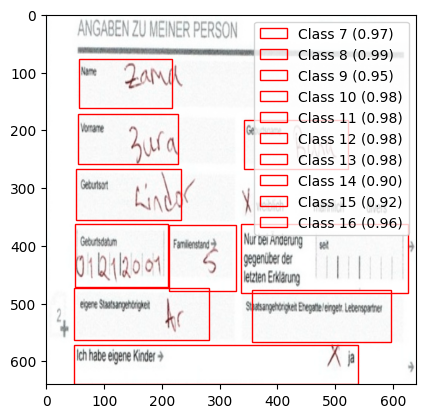

1/1 [==============================] - 0s 150ms/step


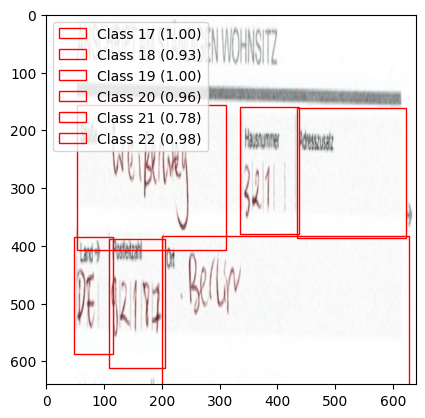

1/1 [==============================] - 0s 150ms/step


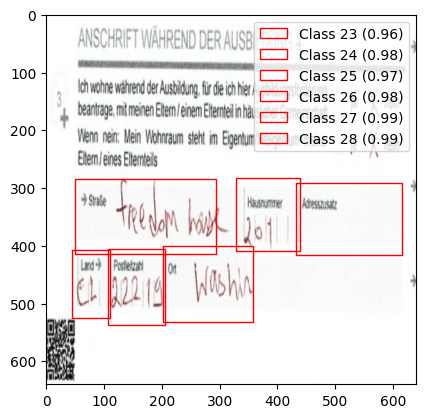

1/1 [==============================] - 0s 155ms/step


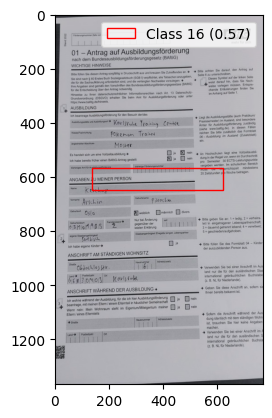

(array([[ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [135.61136, 566.8875 , 620.22095, 647.2693 ]], dtype=float32),
 array([-1, 16], dtype=int64))

In [60]:
#lade bild
image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/0_1.jpg') 
predict_on_image(image_path1, yolo_coco_sub)
image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/1_1.jpg') 
predict_on_image(image_path1, yolo_coco_sub)
image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/2_1.jpg') 
predict_on_image(image_path1, yolo_coco_sub)
image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/3_1.jpg') 
predict_on_image(image_path1, yolo_coco_sub)
image_path2 = (ORIGINAL_IMAGE_PATH+'/image_0011.jpg') 
predict_on_image(image_path2, yolo_coco_sub)